In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import gc

from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Input, Dropout, Dense
from keras.layers import Embedding, GRU, LSTM, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, LambdaCallback, TensorBoard
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
np.random.seed(3)
from tensorflow import set_random_seed
set_random_seed(24)

In [3]:
with open('data_final/reliable_final.pkl', 'rb') as infile:
    reliable = pickle.load(infile)

In [4]:
with open('data_final/unreliable_final.pkl', 'rb') as infile:
    unreliable = pickle.load(infile)

In [5]:
reliable['label'] = 0
unreliable['label'] = 1
data = reliable.append(unreliable).reset_index()

In [6]:
reliable = None
unreliable = None
gc.collect()

28

In [7]:
max_words = 30  # max num words processed for each sentence
max_sentences = 30  # max num sentences processed for each article 
max_vocab = 50000
embedding_dim = 100  # size of pretrained word vectors
attention_dim = 64  # num units in attention layer
GRU_dim = 128  # num units in GRU layer, but it is bidirectional so outputs double this number
batch_size = 64
test_size = 0.2

vector_dir = './embeddings'
vector_file = 'glove.6B.100d.txt'
model_dir = './model_output/glove_100'
tb_logs = './tb_logs/glove_100'

In [8]:
# Split data into train and test sets. Test set will not be used in any way until model is trained.
# The data splits created here will be saved 

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(data['content'], data['label'], test_size=test_size,
                                                    random_state=77, stratify=data['label'])
data = None
gc.collect()

16

In [9]:
# Build vocab word index (dict) from training articles

from collections import Counter 
words = Counter()
for article in X_train:
    for sentence in article:
        sentence = [word.lower() for word in sentence]
        words.update(sentence)
    
#with open('data_final/words.pkl', 'wb') as outfile:
#    pickle.dump(words, outfile)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                    random_state=77, stratify=y_train)

#with open('aws/data/X_train.pkl', 'wb') as outfile:
#    pickle.dump(X_train, outfile)
    
#with open('aws/data/X_val.pkl', 'wb') as outfile:
#    pickle.dump(X_val, outfile)

#with open('aws/data/X_test.pkl', 'wb') as outfile:
#    pickle.dump(X_test, outfile)

#with open('aws/data/y_train.pkl', 'wb') as outfile:
#    pickle.dump(y_train, outfile)
    
#with open('aws/data/y_val.pkl', 'wb') as outfile:
#    pickle.dump(y_val, outfile)

#with open('aws/data/y_test.pkl', 'wb') as outfile:
#    pickle.dump(y_test, outfile)   

An embedding matrix must be constructed so that the embedding layer can look up and use the vector associated with each word. As an intermediary step, the words are first replaced with their respective indices in the word index. The embedding matrix uses these same indices for the lookup.

Only the most common *n* words will be used from the word index. By pre-populating the data and embedding matrices with zeros, any words outside the *n*-word vocabulary or not found in the set of embedding vectors will be represented by a zero or vector of zeros. The GRU and attention layers support masking, which avoids having to process vectors of all zeros.

Trial runs to ensure that the network is working properly and to determine learning rate bounds (to be used with a cyclic learning rate approach) will be conducted with a small subset of the training data comprising 10,000 articles.

In [11]:
word_index = {}
for ix, (word, _) in enumerate(words.most_common(max_vocab)):
    word_index[word] = ix + 1 # The zero index is reserved for masking out-of-vocab words

In [12]:
def create_data_matrix(data, max_sentences=max_sentences, max_words=max_words, max_vocab=max_vocab,
                      word_index=word_index):
    data_matrix = np.zeros((len(data), max_sentences, max_words), dtype='int32')
    for i, article in enumerate(data):
        for j, sentence in enumerate(article):
            if j == max_sentences:
                break
            k = 0
            for word in sentence:
                if k == max_words:
                    break
                ix = word_index.get(word.lower())
                if ix is not None and ix < max_vocab:
                    data_matrix[i, j, k] = ix
                k = k + 1
    return data_matrix  

In [13]:
sample_X = X_train.iloc[0:10000]
sample_y = y_train.iloc[0:10000]
sample_X_train, sample_X_test, sample_y_train, sample_y_test = train_test_split(sample_X, sample_y,
                                                    test_size=test_size, random_state=77, stratify=sample_y)

In [14]:
sample_train_matrix = create_data_matrix(sample_X_train)
sample_test_matrix = create_data_matrix(sample_X_test)

sample_y_train = np.asarray(to_categorical(sample_y_train))
sample_y_test = np.asarray(to_categorical(sample_y_test))

# No validation will be needed for finding the learning rate
find_lr_data = create_data_matrix(sample_X)
find_lr_targets = np.asarray(to_categorical(sample_y))

X_train = None
y_train = None
gc.collect()

386

In [15]:
def store_embeddings(vector_dir=vector_dir, vector_file=vector_file):
    embeddings = {}
    with open(os.path.join(vector_dir, vector_file)) as vectors:
        for line in vectors:
            values = line.split()
            word = values[0]
            weights = np.asarray(values[1:], dtype='float32')
            embeddings[word] = weights
    return embeddings
            
embeddings = store_embeddings()

In [16]:
def create_embedding_matrix(max_vocab=max_vocab, embeddings=embeddings, word_index=word_index,
                            embedding_dim=embedding_dim):
    embedding_matrix = np.zeros((max_vocab + 1, embedding_dim)) # max_vocab + 1 to account for 0 as masking index
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will remain all zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
            
embedding_matrix = create_embedding_matrix()

In [17]:
# Construct attention layer

from tensorflow import matmul
class HierarchicalAttentionNetwork(Layer):
    ''''''
    def __init__(self, attention_dim):
        self.init_weights = initializers.get('glorot_normal')
        self.init_bias = initializers.get('zeros')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super().__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init_weights((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init_bias((self.attention_dim,)))
        self.u = K.variable(self.init_weights((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super().build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):        
        #uit = K.tile(K.expand_dims(self.W, axis=0), (K.shape(x)[0], 1, 1))
        #uit = matmul(x, uit)
        #uit = K.tanh(K.bias_add(uit, self.b))
        #ait = K.dot(uit, self.u)
        #ait = K.squeeze(ait, -1)

        #ait = K.exp(ait)
        
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))
        
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [18]:
def build_model(attention_dim=attention_dim, GRU_dim=GRU_dim, drop=False, drop_pct=None,
                embedding_matrix=embedding_matrix, embedding_dim=embedding_dim, word_index=word_index):
    
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                                input_length=max_words, trainable=False, mask_zero=True)

    #  Layers for processing words in each sentence with attention; output is encoded sentence vector 
    sentence_input = Input(shape=(max_words,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    lstm_word = Bidirectional(GRU(GRU_dim, return_sequences=True))(embedded_sequences)
    attn_word = HierarchicalAttentionNetwork(attention_dim)(lstm_word)
    sentence_encoder = Model(sentence_input, attn_word)
    
    #  Layers for processing sentences in each article with attention; output is prediction
    article_input = Input(shape=(max_sentences, max_words), dtype='int32')
    article_encoder = TimeDistributed(sentence_encoder)(article_input)
    lstm_sentence = Bidirectional(GRU(GRU_dim, return_sequences=True))(article_encoder)
    attn_sentence = HierarchicalAttentionNetwork(attention_dim)(lstm_sentence)
    #  The Adam optimizer also will be tried and can take a dropout layer
    if drop:
        drop_sentence = Dropout(drop_pct)(attn_sentence)
        preds = Dense(2, activation='softmax')(drop_sentence)
    else:
        preds = Dense(2, activation='softmax')(attn_sentence)
    
    return Model(article_input, preds)

In [19]:
# create checkpoints to save information from each training epoch

model_checkpoint = ModelCheckpoint(filepath=model_dir+'weights.{epoch:02d}.hdf5')
tb_checkpoint = TensorBoard(log_dir=tb_logs, histogram_freq=1, batch_size=128, write_graph=False, write_grads=True,
                            write_images=True)

if not os.path.exists(model_dir):
        os.makedirs(model_dir, exist_ok=True)
        
if not os.path.exists(tb_logs):
        os.makedirs(tb_logs, exist_ok=True)

The network will be trained using a cyclic learning rate as proposed in the 2017 paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf). This enables quicker convergence by helping to avoid getting stuck in local minima or saddle points on the loss surface. A [reference implementation](https://github.com/bckenstler/CLR) is available on Github, and a three-post walk-through on [pyimagesearch](https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/) includes code in more detail. The approach has two steps. The first uses a learning rate vs. loss graph to determine the minimum and maximum learning rates. A Keras callback then varies the learning rate back and forth between these two values during training.

In [20]:
start_lr = 1e-8
K.clear_session()
try:
    del model
except NameError:
    pass
model = build_model()
opt = SGD(lr=start_lr, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [21]:
from cyclic.rate_finder import LearningRateFinder
find_lr = LearningRateFinder(model)

In [22]:
# Use a smaller batch size for a more fine-grained tuning of the learning rate
find_lr.find(find_lr_data, find_lr_targets, start_lr=1e-8, end_lr=1., epochs=3, batch_size=32)

Epoch 1/3
10000/10000 [==============================] - 389s 39ms/step - loss: 0.6955 - acc: 0.4459
Epoch 2/3
10000/10000 [==============================] - 383s 38ms/step - loss: 0.6943 - acc: 0.4707
Epoch 3/3
10000/10000 [==============================] - 385s 39ms/step - loss: 0.7367 - acc: 0.5937


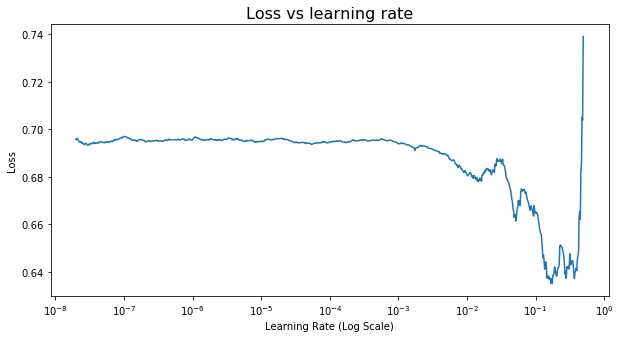

In [59]:
find_lr.plot_loss(skip_begin=35, skip_end=35)

The plot and data show that effective learning (steady drop in loss) begins around $10^{-2.5}$, and
learning becomes erratic and the loss quickly explodes above $10^{-1}$. So the learning rates will cycle between these two values.

In [34]:
from keras.callbacks import Callback
from cyclic.rate_cycler import CyclicLR

Using the min/max learning rates determined above, do test runs with the sample_train and sample_test data to determine the best choices for number of embedding, attention and GRU dimensions. Start with the smallest and see if increasing these dimensions results in significant performance improvement.

In [35]:
clr = CyclicLR(epochs=4, num_samples=8000, batch_size=batch_size)

In [36]:
K.clear_session()
try:
    del model
except NameError:
    pass
model = build_model()
opt = SGD(momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [38]:
model.fit(sample_train_matrix, sample_y_train, validation_data=(sample_test_matrix, sample_y_test),
          batch_size=batch_size, epochs=4, callbacks=[clr])

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 299s 37ms/step - loss: 0.6542 - acc: 0.6070 - val_loss: 0.5866 - val_acc: 0.6930
Epoch 2/4
8000/8000 [==============================] - 322s 40ms/step - loss: 0.5619 - acc: 0.7103 - val_loss: 0.5367 - val_acc: 0.7290
Epoch 3/4
8000/8000 [==============================] - 334s 42ms/step - loss: 0.5232 - acc: 0.7278 - val_loss: 0.5176 - val_acc: 0.7310
Epoch 4/4
8000/8000 [==============================] - 327s 41ms/step - loss: 0.5102 - acc: 0.7364 - val_loss: 0.5102 - val_acc: 0.7410


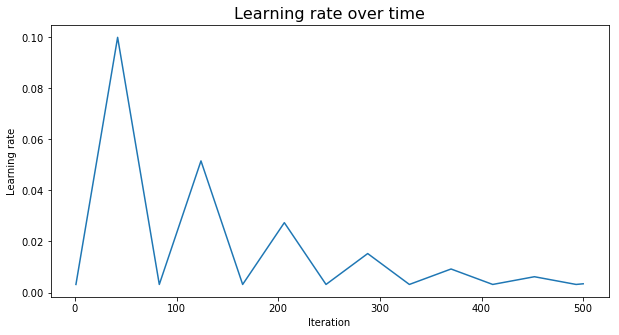

In [60]:
clr.plot_lr()

In [61]:
K.clear_session()
try:
    del model
except NameError:
    pass
model = build_model()
opt = SGD(momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [62]:
model.fit(sample_train_matrix, sample_y_train, validation_data=(sample_test_matrix, sample_y_test),
          batch_size=batch_size, epochs=4, callbacks=[clr])

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 305s 38ms/step - loss: 0.6838 - acc: 0.5785 - val_loss: 0.6686 - val_acc: 0.6485
Epoch 2/4
8000/8000 [==============================] - 308s 39ms/step - loss: 0.6568 - acc: 0.6485 - val_loss: 0.6452 - val_acc: 0.6470
Epoch 3/4
8000/8000 [==============================] - 319s 40ms/step - loss: 0.6308 - acc: 0.6634 - val_loss: 0.6200 - val_acc: 0.6695
Epoch 4/4
8000/8000 [==============================] - 301s 38ms/step - loss: 0.6069 - acc: 0.6791 - val_loss: 0.6077 - val_acc: 0.6610


Nesterov momentum did not improve performance, but the algorithms should also be tried without the cyclic learning rate, after which the Adam optimizer will be tried. A first experiment with Adam showed excessive overfitting, so it will be tried with a dropout layer.

In [63]:
def run_trial(attention_dim=attention_dim, GRU_dim=GRU_dim, embedding_matrix=embedding_matrix, embedding_dim=embedding_dim,
              momentum=0.9, batch_size=batch_size, epochs=4, cyclic=False, nesterov=False, adam=False, drop_pct=0.5,
              X=sample_train_matrix, y=sample_y_train, X_val=sample_test_matrix, y_val=sample_y_test,
              word_index=word_index, scale_factor=0.5, base_lr=10**(-2.5), max_lr=1e-1):
    K.clear_session()
    try:
        del model
    except NameError:
        pass
    
    
    if adam is True:
        opt = Adam()
        model = build_model(attention_dim=attention_dim, GRU_dim=GRU_dim, embedding_matrix=embedding_matrix,
                            embedding_dim=embedding_dim, word_index=word_index, drop=True, drop_pct=drop_pct)
    else:
        opt = SGD(momentum=momentum, nesterov=nesterov)
        model = build_model(attention_dim=attention_dim, GRU_dim=GRU_dim, embedding_matrix=embedding_matrix,
                            embedding_dim=embedding_dim, word_index=word_index)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    
    if cyclic is True:
        clr = CyclicLR(epochs=epochs, num_samples=8000, batch_size=batch_size, scale_factor=scale_factor,
                       base_lr=base_lr, max_lr=max_lr)
        model.fit(X, y, validation_data=(sample_test_matrix, sample_y_test),
                  batch_size=batch_size, epochs=epochs, callbacks=[clr])
    else:
        model.fit(X, y, validation_data=(sample_test_matrix, sample_y_test),
                  batch_size=batch_size, epochs=epochs)

In [64]:
run_trial()  # SGD without cyclic learning rate or Nesterov momentum

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 306s 38ms/step - loss: 0.6676 - acc: 0.6054 - val_loss: 0.6408 - val_acc: 0.6365
Epoch 2/4
8000/8000 [==============================] - 299s 37ms/step - loss: 0.6214 - acc: 0.6491 - val_loss: 0.6315 - val_acc: 0.6180
Epoch 3/4
8000/8000 [==============================] - 300s 37ms/step - loss: 0.5806 - acc: 0.6944 - val_loss: 0.5781 - val_acc: 0.6850
Epoch 4/4
8000/8000 [==============================] - 300s 37ms/step - loss: 0.5461 - acc: 0.7208 - val_loss: 0.5312 - val_acc: 0.7360


In [65]:
run_trial(nesterov=True)  # SGD without cyclic learning rate but with Nesterov momentum

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 314s 39ms/step - loss: 0.6696 - acc: 0.5975 - val_loss: 0.6410 - val_acc: 0.6380
Epoch 2/4
8000/8000 [==============================] - 301s 38ms/step - loss: 0.6056 - acc: 0.6769 - val_loss: 0.5780 - val_acc: 0.6955
Epoch 3/4
8000/8000 [==============================] - 301s 38ms/step - loss: 0.5555 - acc: 0.7107 - val_loss: 0.5543 - val_acc: 0.6895
Epoch 4/4
8000/8000 [==============================] - 300s 38ms/step - loss: 0.5304 - acc: 0.7223 - val_loss: 0.5207 - val_acc: 0.7180


In [66]:
run_trial(adam=True)  # Adam optimizer with default 50% dropout in feed to prediction layer

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 306s 38ms/step - loss: 0.5970 - acc: 0.6629 - val_loss: 0.5262 - val_acc: 0.7240
Epoch 2/4
8000/8000 [==============================] - 300s 38ms/step - loss: 0.4960 - acc: 0.7429 - val_loss: 0.4793 - val_acc: 0.7605
Epoch 3/4
8000/8000 [==============================] - 302s 38ms/step - loss: 0.4610 - acc: 0.7735 - val_loss: 0.4823 - val_acc: 0.7690
Epoch 4/4
8000/8000 [==============================] - 300s 38ms/step - loss: 0.4293 - acc: 0.7981 - val_loss: 0.4779 - val_acc: 0.7580


The 50% dropout somewhat lessened the gap between the training and validation accuracy scores, which was large without dropout, but the model is still overfitting. And the validation accuracy decreased during the fourth epoch to below the second epoch score, while the training accuracy continually increased. Reducing the GRU and/or attention dimensions could help.

In [67]:
run_trial(GRU_dim=64, attention_dim=32, adam=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 161s 20ms/step - loss: 0.6259 - acc: 0.6289 - val_loss: 0.5571 - val_acc: 0.7190
Epoch 2/4
8000/8000 [==============================] - 161s 20ms/step - loss: 0.5257 - acc: 0.7352 - val_loss: 0.5607 - val_acc: 0.6950
Epoch 3/4
8000/8000 [==============================] - 158s 20ms/step - loss: 0.4822 - acc: 0.7635 - val_loss: 0.4759 - val_acc: 0.7655
Epoch 4/4
8000/8000 [==============================] - 163s 20ms/step - loss: 0.4570 - acc: 0.7795 - val_loss: 0.4626 - val_acc: 0.7740


In [68]:
run_trial(GRU_dim=32, attention_dim=16, adam=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 101s 13ms/step - loss: 0.6384 - acc: 0.6294 - val_loss: 0.5801 - val_acc: 0.7245
Epoch 2/4
8000/8000 [==============================] - 97s 12ms/step - loss: 0.5394 - acc: 0.7241 - val_loss: 0.4993 - val_acc: 0.7570
Epoch 3/4
8000/8000 [==============================] - 97s 12ms/step - loss: 0.4960 - acc: 0.7493 - val_loss: 0.5792 - val_acc: 0.6790
Epoch 4/4
8000/8000 [==============================] - 99s 12ms/step - loss: 0.4826 - acc: 0.7571 - val_loss: 0.4687 - val_acc: 0.7740


Smaller attention networks produce quicker models with little or no overfitting through four epochs, but some erratic behavior on the validation set. These might produce good results on the full dataset running for only a few epochs. The validation loss and accuracy for 32/16 network were betterthan the corresponding training scores, indicating that training for more epochs would improve the results. Try some other combinations for the cyclic learning rate model.

In [69]:
run_trial(momentum=0.8, cyclic=True)  # Reduced momentum

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 304s 38ms/step - loss: 0.6508 - acc: 0.6105 - val_loss: 0.6387 - val_acc: 0.6305
Epoch 2/4
8000/8000 [==============================] - 297s 37ms/step - loss: 0.5764 - acc: 0.6994 - val_loss: 0.5551 - val_acc: 0.7165
Epoch 3/4
8000/8000 [==============================] - 307s 38ms/step - loss: 0.5421 - acc: 0.7275 - val_loss: 0.5475 - val_acc: 0.7065
Epoch 4/4
8000/8000 [==============================] - 305s 38ms/step - loss: 0.5287 - acc: 0.7310 - val_loss: 0.5287 - val_acc: 0.7310


Reducing momentum does not give any performance gain, so keep it at 0.9. Try increasing the size of the word embeddings and the vocabulary.

In [70]:
embeddings_200 = store_embeddings(vector_file='glove.6B.200d.txt')
embedding_matrix_200 = create_embedding_matrix(embeddings=embeddings_200, embedding_dim=200)

In [71]:
# Use the default GRU/attention dimensions of 128/64.
run_trial(embedding_matrix=embedding_matrix_200, embedding_dim=200, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 327s 41ms/step - loss: 0.6278 - acc: 0.6320 - val_loss: 0.5544 - val_acc: 0.7080
Epoch 2/4
8000/8000 [==============================] - 323s 40ms/step - loss: 0.5307 - acc: 0.7185 - val_loss: 0.5117 - val_acc: 0.7465
Epoch 3/4
8000/8000 [==============================] - 328s 41ms/step - loss: 0.5184 - acc: 0.7276 - val_loss: 0.5037 - val_acc: 0.7510
Epoch 4/4
8000/8000 [==============================] - 319s 40ms/step - loss: 0.4980 - acc: 0.7485 - val_loss: 0.4960 - val_acc: 0.7460


In [72]:
# Increase the dimensions of the attention network
run_trial(GRU_dim=200, attention_dim=100, embedding_matrix=embedding_matrix_200, embedding_dim=200, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 504s 63ms/step - loss: 0.6466 - acc: 0.6209 - val_loss: 0.5764 - val_acc: 0.7185
Epoch 2/4
8000/8000 [==============================] - 494s 62ms/step - loss: 0.5289 - acc: 0.7266 - val_loss: 0.5095 - val_acc: 0.7350
Epoch 3/4
8000/8000 [==============================] - 494s 62ms/step - loss: 0.5060 - acc: 0.7404 - val_loss: 0.5528 - val_acc: 0.6930
Epoch 4/4
8000/8000 [==============================] - 508s 64ms/step - loss: 0.4864 - acc: 0.7549 - val_loss: 0.4884 - val_acc: 0.7605


In [73]:
# Decrease the attention dimension relative to the GRU dimension.
run_trial(attention_dim=32, embedding_matrix=embedding_matrix_200, embedding_dim=200, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 328s 41ms/step - loss: 0.6891 - acc: 0.5726 - val_loss: 0.6605 - val_acc: 0.6110
Epoch 2/4
8000/8000 [==============================] - 339s 42ms/step - loss: 0.5834 - acc: 0.6923 - val_loss: 0.5355 - val_acc: 0.7270
Epoch 3/4
8000/8000 [==============================] - 331s 41ms/step - loss: 0.5237 - acc: 0.7306 - val_loss: 0.5254 - val_acc: 0.7195
Epoch 4/4
8000/8000 [==============================] - 336s 42ms/step - loss: 0.5102 - acc: 0.7351 - val_loss: 0.5069 - val_acc: 0.7420


The 128/32 attention network is very comparable to the 128/64, althought the more complex 200/100 scores better.

In [74]:
# Increase the vocabulary to 80,000
word_index_80k = {}
for ix, (word, _) in enumerate(words.most_common(80000)):
    word_index_80k[word] = ix + 1 # The zero index is reserved for masking out-of-vocab words

In [75]:
sample_train_matrix_80k = create_data_matrix(sample_X_train, max_vocab=80000, word_index=word_index_80k)
sample_test_matrix_80k = create_data_matrix(sample_X_test, max_vocab=80000, word_index=word_index_80k)

embedding_matrix_100_80k = create_embedding_matrix(max_vocab=80000, word_index=word_index_80k)
embedding_matrix_200_80k = create_embedding_matrix(max_vocab=80000, embeddings=embeddings_200,
                                                   word_index=word_index_80k, embedding_dim=200)

In [76]:
#  Try first with the 100-dimension embedding
run_trial(embedding_matrix=embedding_matrix_100_80k, cyclic=True,
          X=sample_train_matrix_80k, X_val=sample_test_matrix_80k, word_index=word_index_80k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 335s 42ms/step - loss: 0.6531 - acc: 0.6055 - val_loss: 0.5904 - val_acc: 0.6810
Epoch 2/4
8000/8000 [==============================] - 331s 41ms/step - loss: 0.5496 - acc: 0.7157 - val_loss: 0.5283 - val_acc: 0.7225
Epoch 3/4
8000/8000 [==============================] - 326s 41ms/step - loss: 0.5177 - acc: 0.7329 - val_loss: 0.5201 - val_acc: 0.7270
Epoch 4/4
8000/8000 [==============================] - 319s 40ms/step - loss: 0.5090 - acc: 0.7362 - val_loss: 0.5082 - val_acc: 0.7340


In [77]:
run_trial(embedding_matrix=embedding_matrix_200_80k, embedding_dim=200, cyclic=True,
          X=sample_train_matrix_80k, X_val=sample_test_matrix_80k, word_index=word_index_80k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 340s 42ms/step - loss: 0.6315 - acc: 0.6401 - val_loss: 0.5843 - val_acc: 0.6650
Epoch 2/4
8000/8000 [==============================] - 337s 42ms/step - loss: 0.5360 - acc: 0.7154 - val_loss: 0.5298 - val_acc: 0.7270
Epoch 3/4
8000/8000 [==============================] - 335s 42ms/step - loss: 0.5027 - acc: 0.7434 - val_loss: 0.4996 - val_acc: 0.7500
Epoch 4/4
8000/8000 [==============================] - 340s 43ms/step - loss: 0.4912 - acc: 0.7468 - val_loss: 0.4951 - val_acc: 0.7450


In [78]:
run_trial(GRU_dim=200, attention_dim=100, embedding_matrix=embedding_matrix_200_80k, embedding_dim=200, cyclic=True,
          X=sample_train_matrix_80k, X_val=sample_test_matrix_80k, word_index=word_index_80k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 522s 65ms/step - loss: 0.6212 - acc: 0.6391 - val_loss: 0.5885 - val_acc: 0.6900
Epoch 2/4
8000/8000 [==============================] - 520s 65ms/step - loss: 0.5325 - acc: 0.7174 - val_loss: 0.5203 - val_acc: 0.7265
Epoch 3/4
8000/8000 [==============================] - 517s 65ms/step - loss: 0.5031 - acc: 0.7429 - val_loss: 0.5181 - val_acc: 0.7245
Epoch 4/4
8000/8000 [==============================] - 518s 65ms/step - loss: 0.4919 - acc: 0.7490 - val_loss: 0.4955 - val_acc: 0.7500


In [79]:
# Raise the base learning rate a little
run_trial(GRU_dim=200, attention_dim=100, embedding_matrix=embedding_matrix_200_80k, embedding_dim=200, cyclic=True,
          X=sample_train_matrix_80k, X_val=sample_test_matrix_80k, word_index=word_index_80k, base_lr=1e-2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 520s 65ms/step - loss: 0.6622 - acc: 0.5958 - val_loss: 0.5980 - val_acc: 0.6670
Epoch 2/4
8000/8000 [==============================] - 522s 65ms/step - loss: 0.5414 - acc: 0.7175 - val_loss: 0.5156 - val_acc: 0.7345
Epoch 3/4
8000/8000 [==============================] - 519s 65ms/step - loss: 0.5050 - acc: 0.7386 - val_loss: 0.5086 - val_acc: 0.7470
Epoch 4/4
8000/8000 [==============================] - 517s 65ms/step - loss: 0.4950 - acc: 0.7404 - val_loss: 0.4970 - val_acc: 0.7465


In [80]:
#  Try increasing the vocab to 150,000
word_index_150k = {}
for ix, (word, _) in enumerate(words.most_common(150000)):
    word_index_150k[word] = ix + 1 # The zero index is reserved for masking out-of-vocab words
    
sample_train_matrix_150k = create_data_matrix(sample_X_train, max_vocab=150000, word_index=word_index_150k)
sample_test_matrix_150k = create_data_matrix(sample_X_test, max_vocab=150000, word_index=word_index_150k)

embedding_matrix_100_150k = create_embedding_matrix(max_vocab=150000, word_index=word_index_150k)
embedding_matrix_200_150k = create_embedding_matrix(max_vocab=150000, embeddings=embeddings_200,
                                                    word_index=word_index_150k, embedding_dim=200)

In [81]:
run_trial(embedding_matrix=embedding_matrix_100_150k, cyclic=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 318s 40ms/step - loss: 0.6479 - acc: 0.6171 - val_loss: 0.5887 - val_acc: 0.6940
Epoch 2/4
8000/8000 [==============================] - 316s 39ms/step - loss: 0.5557 - acc: 0.7161 - val_loss: 0.5293 - val_acc: 0.7160
Epoch 3/4
8000/8000 [==============================] - 318s 40ms/step - loss: 0.5184 - acc: 0.7275 - val_loss: 0.5126 - val_acc: 0.7420
Epoch 4/4
8000/8000 [==============================] - 316s 40ms/step - loss: 0.5067 - acc: 0.7366 - val_loss: 0.5215 - val_acc: 0.7375


In [82]:
run_trial(GRU_dim=128, attention_dim=32, embedding_matrix=embedding_matrix_200_150k, embedding_dim=200, cyclic=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 309s 39ms/step - loss: 0.6428 - acc: 0.6240 - val_loss: 0.5776 - val_acc: 0.7120
Epoch 2/4
8000/8000 [==============================] - 307s 38ms/step - loss: 0.5404 - acc: 0.7200 - val_loss: 0.5143 - val_acc: 0.7330
Epoch 3/4
8000/8000 [==============================] - 308s 38ms/step - loss: 0.5076 - acc: 0.7361 - val_loss: 0.5137 - val_acc: 0.7300
Epoch 4/4
8000/8000 [==============================] - 309s 39ms/step - loss: 0.4993 - acc: 0.7463 - val_loss: 0.5074 - val_acc: 0.7395


In [83]:
run_trial(GRU_dim=200, attention_dim=100, embedding_matrix=embedding_matrix_200_150k, embedding_dim=200, cyclic=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 485s 61ms/step - loss: 0.6460 - acc: 0.6213 - val_loss: 0.6194 - val_acc: 0.6580
Epoch 2/4
8000/8000 [==============================] - 486s 61ms/step - loss: 0.5470 - acc: 0.7159 - val_loss: 0.5198 - val_acc: 0.7335
Epoch 3/4
8000/8000 [==============================] - 482s 60ms/step - loss: 0.5077 - acc: 0.7409 - val_loss: 0.5033 - val_acc: 0.7480
Epoch 4/4
8000/8000 [==============================] - 484s 61ms/step - loss: 0.4944 - acc: 0.7519 - val_loss: 0.5017 - val_acc: 0.7540


The model with GRU/attention dimensions of 200/100 together with 200-dimension embeddings performed best, with very little difference between the scores for the 50k and 150k vocabs. The former produced better scores, but the latter was more consistent with monotonically decreasing loss and increasing accuracy. Neither, however, betters the results woith the adam optimizer, which needs to be tried with the larger vocabs and higher-dimension embeddings. Earlier experiments showed that increasing the dropout rate to 60% helps with overfitting 

In [84]:
run_trial(GRU_dim=200, attention_dim=100, embedding_matrix=embedding_matrix_200_80k, embedding_dim=200, adam=True,
          X=sample_train_matrix_80k, X_val=sample_test_matrix_80k, word_index=word_index_80k, drop_pct=0.6)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 495s 62ms/step - loss: 0.5797 - acc: 0.6763 - val_loss: 0.5154 - val_acc: 0.7315
Epoch 2/4
8000/8000 [==============================] - 485s 61ms/step - loss: 0.4925 - acc: 0.7474 - val_loss: 0.4669 - val_acc: 0.7835
Epoch 3/4
8000/8000 [==============================] - 486s 61ms/step - loss: 0.4563 - acc: 0.7762 - val_loss: 0.4881 - val_acc: 0.7675
Epoch 4/4
8000/8000 [==============================] - 484s 61ms/step - loss: 0.4159 - acc: 0.8030 - val_loss: 0.4560 - val_acc: 0.7720


In [85]:
run_trial(GRU_dim=128, attention_dim=32, embedding_matrix=embedding_matrix_200_150k, embedding_dim=200, adam=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k, drop_pct=0.6)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 316s 39ms/step - loss: 0.5779 - acc: 0.6796 - val_loss: 0.4887 - val_acc: 0.7560
Epoch 2/4
8000/8000 [==============================] - 310s 39ms/step - loss: 0.4914 - acc: 0.7578 - val_loss: 0.5462 - val_acc: 0.6965
Epoch 3/4
8000/8000 [==============================] - 309s 39ms/step - loss: 0.4561 - acc: 0.7768 - val_loss: 0.4610 - val_acc: 0.7780
Epoch 4/4
8000/8000 [==============================] - 310s 39ms/step - loss: 0.4259 - acc: 0.7964 - val_loss: 0.4386 - val_acc: 0.7935


In [86]:
run_trial(embedding_matrix=embedding_matrix_200_150k, embedding_dim=200, adam=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k, drop_pct=0.6)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 317s 40ms/step - loss: 0.5796 - acc: 0.6796 - val_loss: 0.4830 - val_acc: 0.7665
Epoch 2/4
8000/8000 [==============================] - 317s 40ms/step - loss: 0.4826 - acc: 0.7636 - val_loss: 0.4650 - val_acc: 0.7760
Epoch 3/4
8000/8000 [==============================] - 320s 40ms/step - loss: 0.4433 - acc: 0.7869 - val_loss: 0.4583 - val_acc: 0.7890
Epoch 4/4
8000/8000 [==============================] - 319s 40ms/step - loss: 0.4237 - acc: 0.8007 - val_loss: 0.4388 - val_acc: 0.7955


In [87]:
run_trial(GRU_dim=200, attention_dim=100, embedding_matrix=embedding_matrix_200_150k, embedding_dim=200, adam=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k, drop_pct=0.6)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 496s 62ms/step - loss: 0.5740 - acc: 0.6814 - val_loss: 0.5078 - val_acc: 0.7325
Epoch 2/4
8000/8000 [==============================] - 487s 61ms/step - loss: 0.4811 - acc: 0.7524 - val_loss: 0.4803 - val_acc: 0.7605
Epoch 3/4
8000/8000 [==============================] - 487s 61ms/step - loss: 0.4461 - acc: 0.7826 - val_loss: 0.5100 - val_acc: 0.7330
Epoch 4/4
8000/8000 [==============================] - 487s 61ms/step - loss: 0.4213 - acc: 0.7963 - val_loss: 0.4614 - val_acc: 0.7770


The adam optimizer consistently outperforms SGD with a cyclic learning rate and is significantly quicker. The best performer in terms of scores and consistency was with a 128/64 attention network, the 150k vocab, 200-dimensional embedding vectors and 60% dropout. But the much more compact and less computationally expensive 32/16 network with the 50k vocab, 100-dimension embeddings and 50% dropout performed almost as well. Try one more trial of the larger network with 50% dropout to see if the scores improve without significant overfitting, as well as the very compact 64/32 and 32/16 attention networks that worked well on the smaller vocab and embeddings.

In [88]:
run_trial(embedding_matrix=embedding_matrix_200_150k, embedding_dim=200, adam=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 355s 44ms/step - loss: 0.5815 - acc: 0.6750 - val_loss: 0.5445 - val_acc: 0.6955
Epoch 2/4
8000/8000 [==============================] - 347s 43ms/step - loss: 0.4913 - acc: 0.7499 - val_loss: 0.4951 - val_acc: 0.7510
Epoch 3/4
8000/8000 [==============================] - 347s 43ms/step - loss: 0.4522 - acc: 0.7785 - val_loss: 0.4737 - val_acc: 0.7650
Epoch 4/4
8000/8000 [==============================] - 342s 43ms/step - loss: 0.4176 - acc: 0.8016 - val_loss: 0.4470 - val_acc: 0.7855


In [89]:
run_trial(GRU_dim=64, attention_dim=32, embedding_matrix=embedding_matrix_200_150k, embedding_dim=200, adam=True,
          X=sample_train_matrix_150k, X_val=sample_test_matrix_150k, word_index=word_index_150k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 207s 26ms/step - loss: 0.5865 - acc: 0.6719 - val_loss: 0.5021 - val_acc: 0.7480
Epoch 2/4
8000/8000 [==============================] - 193s 24ms/step - loss: 0.4956 - acc: 0.7470 - val_loss: 0.4566 - val_acc: 0.7825
Epoch 3/4
8000/8000 [==============================] - 189s 24ms/step - loss: 0.4458 - acc: 0.7855 - val_loss: 0.4552 - val_acc: 0.7790
Epoch 4/4
8000/8000 [==============================] - 188s 24ms/step - loss: 0.4284 - acc: 0.7923 - val_loss: 0.4638 - val_acc: 0.7660


Neither the smaller dropout rate nor the smaller network dimensions increased performance. Runs of the two models specified above will be tried with the full datasets on AWS Sagemaker.